In [5]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ppi_py.datasets import load_dataset
from ppi_py import eff_ppi_ols_ci_tuned
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.special import expit
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
alpha = 0.1
ns = np.linspace(500, 5000, 10).astype(
    int
)  # Test for different numbers of labeled examples
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1]
N = 10000
num_trials = 100
d=2
epsilon = 1
coord = 0

theta_star = np.random.randn(d)
print(theta_star)

[0.73743733 0.6360133 ]


In [3]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for s in range(len(sigmas)):
    sigma = sigmas[s]
    for j in tqdm(range(num_trials)):
        X = np.random.multivariate_normal(np.zeros(d), np.eye(d), ns.max())
        Y = X@theta_star + epsilon * np.random.normal(0,  1, ns.max())
        Yhat = Y + sigma*np.random.normal(-2, 1, ns.max())
        X_unlabeled = np.random.multivariate_normal(np.zeros(d), np.eye(d), N)
        Y_unlabeled = X_unlabeled@theta_star + epsilon * np.random.normal(0, 1, N)
        Yhat_unlabeled = Y_unlabeled + sigma*np.random.normal(-2, 1, N)
        for i in range(ns.shape[0]):
            n = ns[i]
            _X = X[:n]
            _Y = Y[:n]
            _Yhat = Yhat[:n]

            # PPI interval
            ppi_ci = eff_ppi_ols_ci_tuned(_X, _Y, _Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, lhat=1)
            classical_ci = eff_ppi_ols_ci_tuned(_X, _Y, _Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, lhat=0)
            ppi_ci_tuned = eff_ppi_ols_ci_tuned(_X, _Y, _Yhat, X_unlabeled, Yhat_unlabeled, coord=coord, alpha=alpha)
            # Append results
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "PPI",
                            "n": n,
                            "lower": ppi_ci[0][coord],
                            "upper": ppi_ci[1][coord],
                            "included": (ppi_ci[0][coord] <= theta_star[coord]) & (ppi_ci[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma
                        }
                    ]
                )
            ]

            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "classical",
                            "n": n,
                            "lower": classical_ci[0][coord],
                            "upper": classical_ci[1][coord],
                            "included": (classical_ci[0][coord] <= theta_star[coord]) & (classical_ci[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma
                        }
                    ]
                )
            ]

            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "tuned PPI",
                            "n": n,
                            "lower": ppi_ci_tuned[0][coord],
                            "upper": ppi_ci_tuned[1][coord],
                            "included": (ppi_ci_tuned[0][coord] <= theta_star[coord]) & (ppi_ci_tuned[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma
                        }
                    ]
                )
            ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████████████████████| 100/100 [08:53<00:00,  5.34s/it]


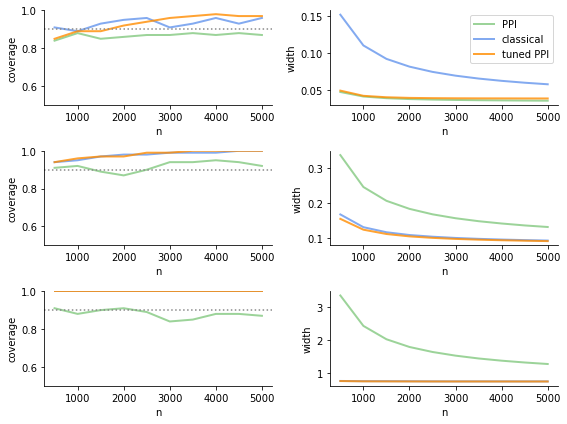

In [4]:
palette = {'tuned PPI' : 'darkorange',
           'PPI' : '#83C980',
           'classical' : 'cornflowerblue'}
linewidth=2
n_unique_sigmas = df.sigma.nunique()

fig, axs = plt.subplots(nrows=n_unique_sigmas, ncols=2, figsize=(8,2*n_unique_sigmas))
for s in range(n_unique_sigmas): 
    cvg_ax = axs[s, 0]
    sz_ax = axs[s, 1]
    legend = False if s > 0 else True
    sns.lineplot(ax=cvg_ax, data=df[df.sigma == sigmas[s]], x="n", y="included", linewidth=linewidth, errorbar=None, hue="method", legend=False, palette=palette, alpha=0.8)
    sns.lineplot(ax=sz_ax, data=df[df.sigma == sigmas[s]], x="n", y="width", linewidth=linewidth, errorbar=None, hue="method", legend=legend, palette=palette, alpha=0.8)
    cvg_ax.set_ylabel("coverage")
    cvg_ax.set_ylim([0.5,1])
    cvg_ax.axhline(y=1-alpha, color="#888888", linestyle='dotted')
    if legend:
        sz_ax.legend_.set_title(None)
    
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs('./plots',exist_ok=True)
plt.savefig('./plots/tuned-PPI-ols.pdf')